### Intro

* Dimesionality reduction is lossy. It may speed up training but can degrade result quality. Also makes pipelines more complex. Try using original data before considering dimensionality reduction.
* Very useful for visualization (2D, 3D representations more intuitive.)

* Two main approaches: **projection**, **manifold learning**.
* Three most popular techniques: **PCA**, **Kernel PCA**, **LLE**.

### Curse of Dimensionality
* Many things behave differently in high-D space.

1) Most points in high-D hypercube will be very close to a border.

2) Distances between random points much greater (very high probability of sparse matrix representation).
* In 2D: ~0.52
* In 3D: ~0.66
* In 1,000,000D: ~408 ~ sqrt(1000000/6)

### Approaches: Projection
* Most dataset features are concentrated in a few dimensions - not uniformly across all. Much learnable training can be found in low-D subspace.

In [1]:
import numpy as np
import numpy.random as rnd

In [2]:
# build a 3D dataset

rnd.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * rnd.randn(m)

# mean-normalize the data
X = X - X.mean(axis=0)

# apply PCA to reduce to 2D
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

# recover 3D points projected on 2D plane
X2D_inv = pca.inverse_transform(X2D)

In [3]:
# utility to draw 3D arrows
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

# express plane as function of x,y
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

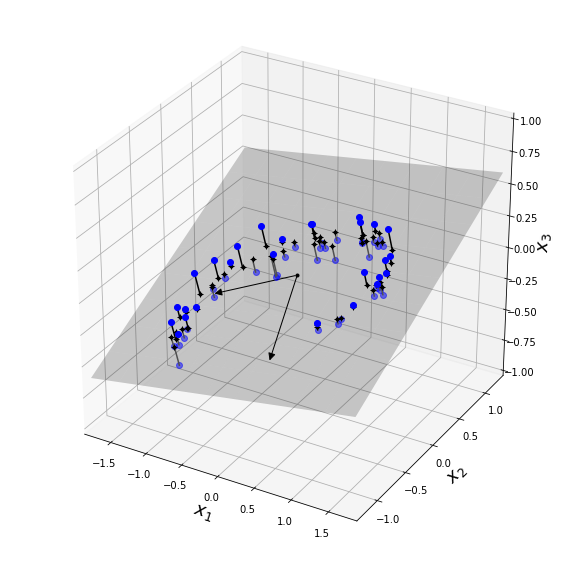

In [4]:
# plot 3D dataset, plane & projections

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X2D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X2D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X2D_inv[i, 2]:
        ax.plot([X[i][0], X2D_inv[i][0]], [X[i][1], X2D_inv[i][1]], [X[i][2], X2D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X2D_inv[i][0]], [X[i][1], X2D_inv[i][1]], [X[i][2], X2D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X2D_inv[:, 0], X2D_inv[:, 1], X2D_inv[:, 2], "k+")
ax.plot(X2D_inv[:, 0], X2D_inv[:, 1], X2D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

#save_fig("dataset_3d_plot")
plt.show()

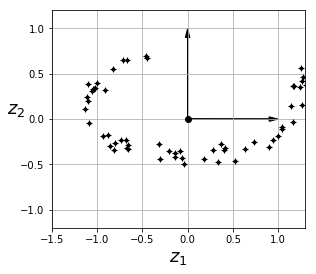

In [5]:
# 2D projection equivalent:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
plt.show()

### Approaches: Manifolds
* Manifolds = shapes that can be bent/twisted in higher-D space.
* ex: "Swiss roll" problem

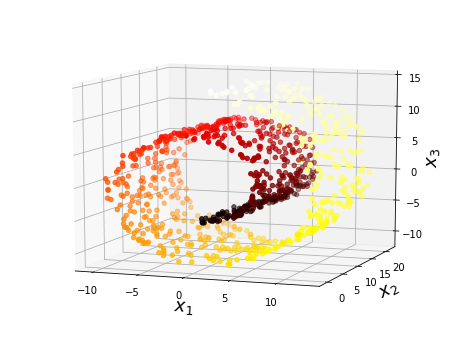

In [6]:
# Swiss roll visualization:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

#save_fig("swiss_roll_plot")
plt.show()

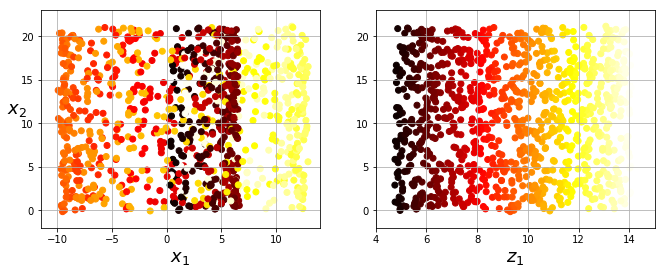

In [7]:
# "squashed" swiss roll visualization:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

#save_fig("squished_swiss_roll_plot")
plt.show()

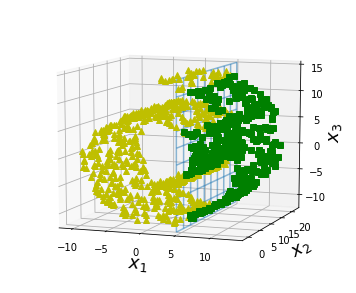

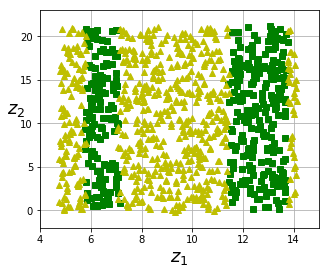

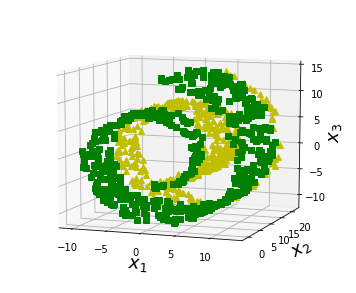

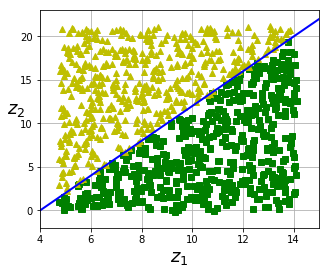

In [8]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]

ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

#save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

#save_fig("manifold_decision_boundary_plot2")
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

#save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

#save_fig("manifold_decision_boundary_plot4")
plt.show()

# Lesson learned (below):
# Unrolling a dataset to a lower dimension doesn't necessarily lead to
# a simpler representation.

### PCA (Principal Component Analysis)
* Most popular DR algorithm
* 1) Finds hyperplane that lies closest to the data
* 2) Projects data onto it

### Preserving Variance
* Below: simple 2D dataset projected onto 3 different axes.
* Projection on solid line preserves the maximum variance. (Therefore less likely to lose information.)

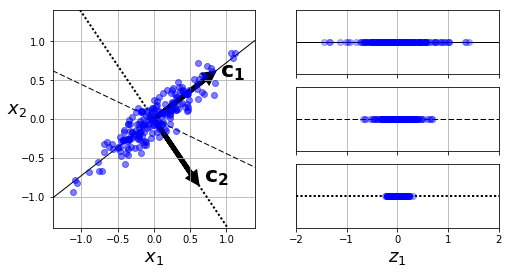

In [9]:
angle = np.pi / 5
stretch = 5
m = 200

rnd.seed(3)
X = rnd.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

#save_fig("pca_best_projection")
plt.show()

### Principal Components
* PCA finds axis responsible for largest amount of variance in dataset.
* Also finds 2nd axis, responsible for next largest amount.
* If higher-D dataset, PCA also finds 3rd axis...
* Repeat for # of dimensions in the dataset.
* Each axis vector is called a **principal component**. (PC)

* PCs found using **Singular Value Decomposition (SVD)**, a matrix factorization technique.
* SVD decomposes training set matrix X into dot product of three matrices.
* Note: PCA assumes data is centered around origin. Scikit PCA will adjust data for you if needed.

In [10]:
# use NumPy svd() to get principal components of training set,
# then extract 1st two PCs.

X_centered = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X_centered)

c1, c2 = V.T[:,0], V.T[:,1]
print(c1,c2)

[-0.79644131 -0.60471583] [-0.60471583  0.79644131]


### Projecting Training Data Down to d Dimensions
* Done by computing dot product of training data (X) by matrix containing the first d principal components (Wd).

In [11]:
# project training set onto plane defined by 1st two PCs.

W2 = V.T[:, :2]
X2D = X_centered.dot(W2)
print(X2D)

[[ -8.96088137e-01   2.61576283e-02]
 [ -4.53603363e-02  -1.85948860e-01]
 [  1.38359166e-01  -3.11666166e-02]
 [  4.16315780e-02  -6.04371773e-02]
 [  2.18583744e-02  -4.58726693e-02]
 [  6.53868464e-01   1.03673047e-01]
 [ -4.45218566e-01   1.63002740e-01]
 [ -2.52100754e-02  -3.96098381e-02]
 [  2.74828447e-01  -1.47486328e-01]
 [ -4.89804685e-01  -1.19064333e-01]
 [  5.91772943e-01  -6.68825324e-03]
 [ -7.44460369e-01   9.37220434e-03]
 [  5.12230114e-01  -5.91117152e-02]
 [ -3.13266691e-01  -2.12641588e-02]
 [  3.83765553e-01  -1.35145070e-02]
 [ -3.77664930e-01   1.91087392e-01]
 [  6.22192127e-01  -4.81326634e-02]
 [  4.05843018e-01  -2.32002753e-01]
 [  4.62900292e-01  -9.12474313e-02]
 [ -5.62638042e-01  -2.36637544e-02]
 [  8.09046208e-01   8.31463215e-02]
 [  1.80719622e-01  -1.69142171e-01]
 [  2.98447518e-01  -5.11785151e-02]
 [  4.35729072e-01   1.35618235e-02]
 [  1.12339132e+00  -1.68707469e-03]
 [ -5.09329756e-01   7.59538223e-02]
 [ -5.57383436e-01   1.01605408e-01]
 

### Scikit PCA
* Uses SVD decomposition as before.
* You can access each PC using *components_* variable. (

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

print(pca.components_[0])
print(pca.components_.T[:,0])

[-0.79644131 -0.60471583]
[-0.79644131 -0.60471583]


### Explained Variance Ratio
* Very useful metric: proportion of dataset's variance along the axis of each PC component.

In [13]:
# 95% of dataset variance explained by 1st axis.
print(pca.explained_variance_ratio_)

[ 0.95369864  0.04630136]


### Choosing Right #Dimensions
* No need to choose arbitrary #dimensions. Instead pick d that cumulatively accounts for a sufficient amount, ex: 95%.

In [14]:
# find minimum d to preserve 95% of training set variance
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)

1


### PCA for Compression
* Example applying PCA to MNIST dataset with 95% preservation = results in ~150 features (original = 28x28 = 784)

In [15]:
#MNIST compression:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_mldata

#mnist = fetch_mldata('MNIST original')
mnist_path = "./mnist-original.mat"

from scipy.io import loadmat
mnist_raw = loadmat(mnist_path)
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
    }

X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

X = X_train

pca = PCA()
pca.fit(X)
d = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
d

154

In [16]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)
pca.n_components_

154

In [17]:
# did you hit your 95% minimum?
np.sum(pca.explained_variance_ratio_)

0.9503623084769206

In [18]:
# use inverse_transform to decompress back to 784 dimensions
X_mnist = X_train

pca = PCA(n_components = 154)
X_mnist_reduced = pca.fit_transform(X_mnist)
X_mnist_recovered = pca.inverse_transform(X_mnist_reduced)

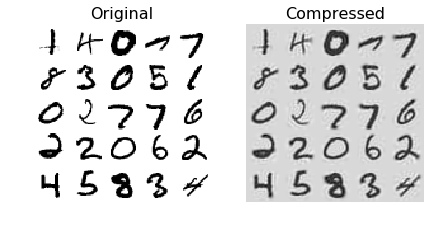

In [19]:
import matplotlib
import matplotlib.pyplot as plt

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_mnist[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_mnist_recovered[::2100])
plt.title("Compressed", fontsize=16)
#save_fig("mnist_compression_plot")
plt.show()

### Incremental PCA
* PCA normally requires entire dataset in memory for SVD algorithm.
* **Incremental PCA (IPCA)** splits dataset into batches.

In [20]:
# split MNIST into 100 minibatches using Numpy array_split()
# reduce MNIST down to 154 dimensions as before.
# note use of partial_fit() for each batch.

from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(X_mnist, n_batches):
    print(".", end="")
    inc_pca.partial_fit(X_batch)

X_mnist_reduced_inc = inc_pca.transform(X_mnist)

....................................................................................................

In [21]:
# alternative: Numpy memmap class (use binary array on disk as if it was in memory)

filename = "my_mnist.data"

X_mm = np.memmap(
    filename, dtype='float32', mode='write', shape=X_mnist.shape)

X_mm[:] = X_mnist
del X_mm

In [22]:
X_mm = np.memmap(filename, dtype='float32', mode='readonly', shape=X_mnist.shape)

batch_size = len(X_mnist) // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [23]:
rnd_pca = PCA(
    n_components=154, 
    random_state=42, 
    svd_solver="randomized")

X_reduced = rnd_pca.fit_transform(X_mnist)

In [24]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(
        n_components=n_components)
    inc_pca     = IncrementalPCA(
        n_components=154, 
        batch_size=500)
    rnd_pca     = PCA(
        n_components=154, 
        random_state=42, 
        svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_mnist)
        t2 = time.time()
        print(pca.__class__.__name__, t2 - t1, "seconds")

n_components = 2
PCA 1.308387279510498 seconds
IncrementalPCA 18.326093673706055 seconds
PCA 3.998342514038086 seconds
n_components = 10
PCA 1.4705824851989746 seconds
IncrementalPCA 16.598721742630005 seconds
PCA 4.156355619430542 seconds
n_components = 154
PCA 4.129154682159424 seconds
IncrementalPCA 16.597434043884277 seconds
PCA 4.0131142139434814 seconds


### Randomized PCA
* Stochastic algorithm, quickly finds approximation of 1st d components. Dramatically faster.

In [25]:
rnd_pca = PCA(n_components=154, svd_solver="randomized")

t1 = time.time()
X_reduced = rnd_pca.fit_transform(X_mnist)
t2 = time.time()
print(t2-t1, "seconds")

4.414088487625122 seconds


### Kernel PCA
* Use kernel trick to map instances into higher-D feature spaces. This enables non-linear classification & regression with SVMs.
* Good at preserving clusters after projecton.

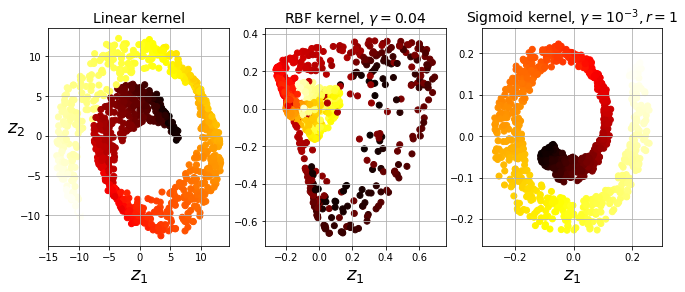

In [26]:
# Below: Swiss roll reduced to 2D using 3 techniques:
# 1) linear kernel (equiv to PCA)
# 2) RBF kernel
# 3) sigmoid kernel (logistic)

from sklearn.decomposition import KernelPCA

X, t = make_swiss_roll(
    n_samples=1000, 
    noise=0.2, 
    random_state=42)

lin_pca = KernelPCA(
    n_components = 2, 
    kernel="linear", 
    fit_inverse_transform=True)

rbf_pca = KernelPCA(
    n_components = 2, 
    kernel="rbf", 
    gamma=0.0433, 
    fit_inverse_transform=True)

sig_pca = KernelPCA(
    n_components = 2, 
    kernel="sigmoid", 
    gamma=0.001, 
    coef0=1, 
    fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))

for subplot, pca, title in (
    (131, lin_pca, "Linear kernel"), 
    (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
    (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

#save_fig("kernel_pca_plot")
plt.show()

### Selecting a Kernel & Hyperparameters
* Dimensionality reduction = prep for supervised learning task
* Can use grid search to select kernel & params

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

# best kernel & params?
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


* Another (unsupervised approach): select kernel & params with **lowest reconstruction error**. Not as easy as with linear PCA.

In [28]:
rbf_pca = KernelPCA(
    n_components = 2, 
    kernel="rbf", 
    gamma=0.0433,
    fit_inverse_transform=True) # perform reconstruction

X_reduced  = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

# return reconstruction pre-image error
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

32.786308795766082

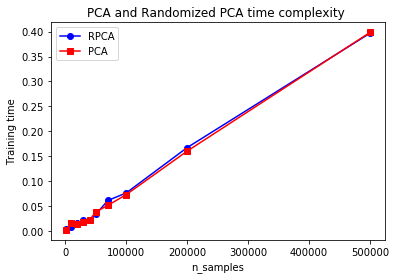

In [29]:
times_rpca = []
times_pca = []
sizes = [1000, 10000,  20000,  30000, 40000, 50000, 70000, 
              100000, 200000, 500000]

for n_samples in sizes:

    X = rnd.randn(n_samples, 5)

    pca = PCA(
        n_components = 2, 
        random_state=42, 
        svd_solver="randomized")

    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    
    pca = PCA(n_components = 2)
    
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")
plt.show()

### LLE (Locally Linear Embedding)
* Powerful nonlinear dimensionality reduction tool
* Manifold Learning; doesn't rely on projections.
* LLE measures how each instance relates to closest neighbors, then looks for low-D representation where local relations are best preserved.

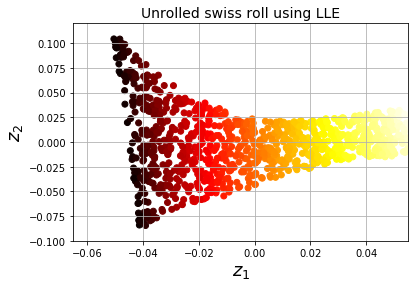

In [30]:
# Use LLE to unroll a Swiss Roll.

from sklearn.manifold import LocallyLinearEmbedding

X, t = make_swiss_roll(
    n_samples=1000, 
    noise=0.2, 
    random_state=41)

lle = LocallyLinearEmbedding(
    n_neighbors=10, 
    n_components=2, 
    random_state=42)

X_reduced = lle.fit_transform(X)

plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

#save_fig("lle_unrolling_plot")
plt.show()

* 1st: For each instance, LLE finds k nearest neighbors & tries to reconstruct instance as linear function of neighbors (weights such that squared distance is minimum). 
* Weight matrix W now encodes all local linear relations between instances.
* 2nd: Map instances into d-dimensional space & preserve relationship data
* Scikit computational complexity: 
- finding K nearest neighbors: O(m x log(m) x n x log(k))
- weight optimization: O(m x n x k^3)
- constructing low-d representations: O(d x m^2)

### MDS, Isomap, t-SNE, LDA

In [31]:
from sklearn.manifold import MDS
mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [32]:
from sklearn.manifold import Isomap
isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [33]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_reduced_tsne = tsne.fit_transform(X)

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

/home/bjpcjp/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


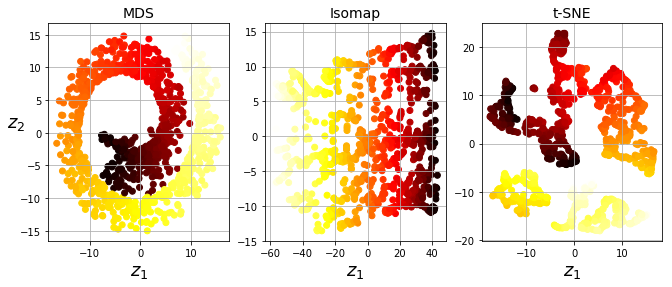

In [35]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

#save_fig("other_dim_reduction_plot")
plt.show()